# DQN + A2C (CIFAR-10) integrated notebook

This notebook integrates the original DQN pipeline and an A2C implementation, adapts both to CIFAR-10 images (converted to 64x64 grayscale), trains a small autoencoder, then trains both RL algorithms on an ImageTransmission environment that simulates selecting latent truncation K for transmission.

Notes:
- Encoder and Decoder are defined inline (no external files).
- Default (nodest) hyperparameters are chosen to keep runtime reasonable. Change the hyperparameters in the top cell where marked for larger experiments.
- The notebook saves sample images and comparison plots to the working directory.


In [1]:
!pip install "gymnasium[mujoco]"
import os
os.environ["MUJOCO_GL"] = "egl"

In [2]:
# Cell 1: imports and (changeable) hyperparameters - change values below for larger experiments
import os
import math
import random
from collections import deque, namedtuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision
import torchvision.transforms as T

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# ----------------- Change these for larger experiments -----------------
# Autoencoder training
AE_EPOCHS = 100            # nodest default; for serious run: try 50+ !CHANGED to 100, was 12!
AE_BATCH = 128            # batch size for AE training
# RL training
DQN_EPISODES = 2500       # nodest default; for serious run: try 1000+ !CHANGED to 2500, was 400!
A2C_EPISODES = 2500        # nodest default; for serious run: try 1000+ !CHANGED to 2500, was 400!
STEPS_PER_EP = 100         # how many images per episode (short for demo) !CHANGED to 100, was 50!
# Preview / AE / RL sizes
CODE_DIM = 128            # must match encoder/decoder code_dim
N_PREV = 5                # number of previous latents used by decoder
PREVIEW_DIM = 16          # how many elements of z we expose as observation
K_CHOICES = [128, 96, 64, 32]
LAMBDA = 0.01             # penalty on K in reward
# DQN hyperparams
BATCH_SIZE = 64
GAMMA = 0.99
LR_DQN = 1e-3
REPLAY_CAP = 10000
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.995
# A2C hyperparams
LR_A2C = 1e-3
N_STEPS = 10              # n-step bootstrap length; increase for performance
PRINT_INTERVAL = 20
SEED = 42
# ---------------------------------------------------------------------
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)


Device: cpu


In [ ]:
# Cell 2: Inline Encoder and Decoder (integrated instead of separate files)
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_ch=1, code_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_ch, 16, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.fc_enc = None
        self.code_dim = code_dim

    def forward(self, x):
        B = x.shape[0]
        feat = self.conv(x)
        if self.fc_enc is None:
            flat_dim = feat.numel() // B
            self.fc_enc = nn.Linear(flat_dim, self.code_dim).to(x.device)
            print(f" Initialized fc_enc with input size {flat_dim}")
        flat = feat.reshape(B, -1)
        z = self.fc_enc(flat)
        return z

class Decoder(nn.Module):
    def __init__(self, code_dim=128, n_prev=5, output_ch=1):
        super().__init__()
        self.n_prev = n_prev
        self.code_dim = code_dim
        total_dim = (n_prev + 1) * code_dim

        self.fc_dec = nn.Linear(total_dim, 64 * 8 * 8)

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, output_ch, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def decode(self, z, prev_latents=None):
        if prev_latents is not None:
            B = z.size(0)
            prev = prev_latents.view(B, self.n_prev * self.code_dim)
            z_cat = torch.cat([z, prev], dim=1)
        else:
            B = z.size(0)
            zeros = torch.zeros(B, self.n_prev * self.code_dim, device=z.device)
            z_cat = torch.cat([z, zeros], dim=1)

        feat = self.fc_dec(z_cat)
        feat = feat.view(-1, 64, 8, 8)
        rec = self.deconv(feat)
        return rec

    def forward(self, z, prev_latents=None):
        return self.decode(z, prev_latents)

# instantiate AE models
encoder = Encoder(input_ch=1, code_dim=CODE_DIM).to(DEVICE)
decoder = Decoder(code_dim=CODE_DIM, n_prev=N_PREV, output_ch=1).to(DEVICE)

# Print small sanity check
x = torch.randn(2,1,64,64, device=DEVICE)
with torch.no_grad():
    z = encoder(x)
    rec = decoder.decode(z, None)
print('AE forward shapes:', z.shape, rec.shape)


✅ Initialized fc_enc with input size 4096
AE forward shapes: torch.Size([2, 128]) torch.Size([2, 1, 64, 64])


In [4]:
# Cell 3: Load CIFAR-10, convert to grayscale 64x64, show sample grid
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid, save_image

transform = T.Compose([
    T.Resize((64,64)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=AE_BATCH, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=AE_BATCH, shuffle=False, num_workers=2)

# save first 25 test images grid (originals)
os.makedirs('outputs', exist_ok=True)
sample_imgs = []
for i, (img, lbl) in enumerate(testset):
    sample_imgs.append(img)
    if i >= 24:
        break
grid = make_grid(torch.stack(sample_imgs), nrow=5, pad_value=1.0)
save_image(grid, 'outputs/cifar10_test_25_originals.png')
print('Saved outputs/cifar10_test_25_originals.png')


100%|██████████| 170M/170M [01:32<00:00, 1.84MB/s]   


Saved outputs/cifar10_test_25_originals.png


In [5]:
# Cell 4: Train small autoencoder (MSE) - default modest epochs, change AE_EPOCHS above for longer training
ae_optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
ae_loss_hist = []

for epoch in range(1, AE_EPOCHS+1):
    running = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        ae_optimizer.zero_grad()
        z = encoder(imgs)
        rec = decoder.decode(z, None)
        loss = F.mse_loss(rec, imgs)
        loss.backward()
        ae_optimizer.step()
        running += loss.item() * imgs.size(0)
    epoch_loss = running / len(trainset)
    ae_loss_hist.append(epoch_loss)
    print(f'AE Epoch {epoch}/{AE_EPOCHS} | loss = {epoch_loss:.6f}')

# save a reconstruction grid after AE training (full code)
encoder.eval(); decoder.eval()
with torch.no_grad():
    sample_batch = torch.stack(sample_imgs).to(DEVICE)
    z = encoder(sample_batch)
    rec_full = decoder.decode(z, None)
    grid_rec = make_grid(rec_full.cpu(), nrow=5, pad_value=1.0)
    save_image(grid_rec, 'outputs/cifar10_test_25_after_AE.png')
print('Saved outputs/cifar10_test_25_after_AE.png')
# also save AE models to disk (optional)
torch.save(encoder.state_dict(), 'outputs/encoder.pth')
torch.save(decoder.state_dict(), 'outputs/decoder.pth')
print('Saved AE weights to outputs/')


AE Epoch 1/100 | loss = 0.018209
AE Epoch 2/100 | loss = 0.005775
AE Epoch 3/100 | loss = 0.003659
AE Epoch 4/100 | loss = 0.002719
AE Epoch 5/100 | loss = 0.002285
AE Epoch 6/100 | loss = 0.002069
AE Epoch 7/100 | loss = 0.001967
AE Epoch 8/100 | loss = 0.001917
AE Epoch 9/100 | loss = 0.001888
AE Epoch 10/100 | loss = 0.001864
AE Epoch 11/100 | loss = 0.001847
AE Epoch 12/100 | loss = 0.001834
AE Epoch 13/100 | loss = 0.001818
AE Epoch 14/100 | loss = 0.001799
AE Epoch 15/100 | loss = 0.001790
AE Epoch 16/100 | loss = 0.001777
AE Epoch 17/100 | loss = 0.001769
AE Epoch 18/100 | loss = 0.001756
AE Epoch 19/100 | loss = 0.001750
AE Epoch 20/100 | loss = 0.001742
AE Epoch 21/100 | loss = 0.001735
AE Epoch 22/100 | loss = 0.001728
AE Epoch 23/100 | loss = 0.001724
AE Epoch 24/100 | loss = 0.001715
AE Epoch 25/100 | loss = 0.001713
AE Epoch 26/100 | loss = 0.001705
AE Epoch 27/100 | loss = 0.001704
AE Epoch 28/100 | loss = 0.001695
AE Epoch 29/100 | loss = 0.001693
AE Epoch 30/100 | loss 

In [6]:
# Cell 5: ImageTransmissionEnv (uses trainset iterator)
class ImageTransmissionEnv:
    def __init__(self, dataset, encoder, decoder, device, preview_dim=PREVIEW_DIM, lambda_penalty=LAMBDA, max_steps=STEPS_PER_EP):
        self.dataset = dataset
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.preview_dim = preview_dim
        self.lambda_penalty = lambda_penalty
        self.max_steps = max_steps
        self.length_levels = K_CHOICES
        self.idx = 0
        self.step_count = 0
        self.buffer = deque(maxlen=N_PREV)

    def reset(self):
        self.step_count = 0
        self.buffer.clear()
        # start from current idx image
        img, _ = self.dataset[self.idx]
        self.current_img = img.to(self.device).unsqueeze(0)
        with torch.no_grad():
            z = self.encoder(self.current_img)
        self.buffer.append(z.detach().cpu())
        obs = z[0, :self.preview_dim].cpu().numpy().astype(np.float32)
        return obs

    def step(self, action_idx):
        K = self.length_levels[int(action_idx)]
        with torch.no_grad():
            z = self.encoder(self.current_img)
        z_limited = z.clone()
        if K < z.shape[1]:
            z_limited[:, K:] = 0.0
        prev = None if len(self.buffer) < N_PREV else torch.cat(list(self.buffer), dim=0).unsqueeze(0).view(1, N_PREV, CODE_DIM).to(self.device)
        with torch.no_grad():
            rec = self.decoder.decode(z_limited.to(self.device), prev_latents=prev)
        mse = F.mse_loss(rec, self.current_img).item()
        psnr = 10.0 * math.log10(1.0 / (mse + 1e-8))
        penalty = self.lambda_penalty * (K / float(CODE_DIM))
        reward = psnr - penalty
        # advance to next image in dataset (circular)
        self.idx = (self.idx + 1) % len(self.dataset)
        img, _ = self.dataset[self.idx]
        self.current_img = img.to(self.device).unsqueeze(0)
        with torch.no_grad():
            z_next = self.encoder(self.current_img)
        self.buffer.append(z_next.detach().cpu())
        self.step_count += 1
        done = (self.step_count >= self.max_steps)
        obs = z_next[0, :self.preview_dim].cpu().numpy().astype(np.float32)
        return obs, float(reward), bool(done), {}

    def seed(self, s):
        random.seed(s); np.random.seed(s); torch.manual_seed(s)

env = ImageTransmissionEnv(trainset, encoder, decoder, DEVICE)
obs_dim = PREVIEW_DIM
n_actions = len(K_CHOICES)
print('Env obs_dim, n_actions =', obs_dim, n_actions)


Env obs_dim, n_actions = 16 4


In [7]:
# Cell 6: DQN (adapted to ImageTransmissionEnv)
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_obs, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_obs, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    def forward(self, x):
        return self.net(x)

policy_net = DQN(obs_dim, n_actions).to(DEVICE)
target_net = DQN(obs_dim, n_actions).to(DEVICE)
target_net.load_state_dict(policy_net.state_dict())
optimizer_dqn = optim.Adam(policy_net.parameters(), lr=LR_DQN)
memory = ReplayMemory(REPLAY_CAP)
steps_done = 0
dqn_reward_hist = []
dqn_length_hist = []
dqn_loss_hist = []

def select_action_dqn(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            return int(policy_net(s).argmax(dim=1).item())
    else:
        return random.randrange(n_actions)

def optimize_model_dqn():
    if len(memory) < BATCH_SIZE:
        return None
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    state_batch = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=DEVICE)
    action_batch = torch.tensor(batch.action, dtype=torch.int64, device=DEVICE).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=DEVICE).unsqueeze(1)
    non_final_mask = torch.tensor([s is not None for s in batch.next_state], device=DEVICE, dtype=torch.bool)
    non_final_next = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32, device=DEVICE) if any(non_final_mask) else None
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, 1, device=DEVICE)
    with torch.no_grad():
        if non_final_next is not None:
            next_state_values[non_final_mask] = target_net(non_final_next).max(1)[0].unsqueeze(1)
    expected_values = reward_batch + GAMMA * next_state_values
    loss = nn.SmoothL1Loss()(state_action_values, expected_values.detach())
    optimizer_dqn.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 5.0)
    optimizer_dqn.step()
    return loss.item()

# DQN training loop (modest defaults)
for ep in range(1, DQN_EPISODES+1):
    obs = env.reset()
    total_reward = 0.0
    for t in range(STEPS_PER_EP):
        action = select_action_dqn(obs)
        next_obs, reward, done, info = env.step(action)
        memory.push(obs, action, None if done else next_obs, reward)
        obs = next_obs
        total_reward += reward
        l = optimize_model_dqn()
        if l is not None:
            dqn_loss_hist.append(l)
        # soft update
        for tp, pp in zip(target_net.parameters(), policy_net.parameters()):
            tp.data.copy_(TAU * pp.data + (1.0 - TAU) * tp.data)
        if done:
            break
    dqn_reward_hist.append(total_reward)
    dqn_length_hist.append(t+1)
    if ep % 20 == 0:
        print(f'DQN Episode {ep}/{DQN_EPISODES} | Reward: {total_reward:.2f} | avg(last20) = {np.mean(dqn_reward_hist[-20:]):.2f}')

torch.save(policy_net.state_dict(), 'outputs/dqn_policy.pth')
print('Saved outputs/dqn_policy.pth')


C:\Users\Victoriya\AppData\Local\Temp\ipykernel_20920\1562024201.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  non_final_next = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32, device=DEVICE) if any(non_final_mask) else None


DQN Episode 20/2500 | Reward: 2463.03 | avg(last20) = 2240.57
DQN Episode 40/2500 | Reward: 2540.77 | avg(last20) = 2524.20
DQN Episode 60/2500 | Reward: 2747.20 | avg(last20) = 2612.30
DQN Episode 80/2500 | Reward: 2714.03 | avg(last20) = 2629.53
DQN Episode 100/2500 | Reward: 2626.55 | avg(last20) = 2632.82
DQN Episode 120/2500 | Reward: 2586.63 | avg(last20) = 2610.17
DQN Episode 140/2500 | Reward: 2577.47 | avg(last20) = 2614.34
DQN Episode 160/2500 | Reward: 2650.27 | avg(last20) = 2587.26
DQN Episode 180/2500 | Reward: 2580.80 | avg(last20) = 2613.26
DQN Episode 200/2500 | Reward: 2558.60 | avg(last20) = 2595.70
DQN Episode 220/2500 | Reward: 2687.95 | avg(last20) = 2592.42
DQN Episode 240/2500 | Reward: 2587.34 | avg(last20) = 2617.62
DQN Episode 260/2500 | Reward: 2592.03 | avg(last20) = 2603.53
DQN Episode 280/2500 | Reward: 2590.56 | avg(last20) = 2599.20
DQN Episode 300/2500 | Reward: 2642.89 | avg(last20) = 2598.80
DQN Episode 320/2500 | Reward: 2643.26 | avg(last20) = 2589

In [8]:
# Cell 7: A2C implementation (on same ImageTransmissionEnv)
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
        )
        self.policy_head = nn.Linear(128, n_actions)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        logits = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs=probs)
        return dist, value

    def forward(self, x):
        x = self.shared(x)
        logits = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs=probs)
        return dist, value

ac = ActorCritic(obs_dim, n_actions).to(DEVICE)
optimizer_ac = optim.Adam(ac.parameters(), lr=LR_A2C)

a2c_reward_hist = []
a2c_length_hist = []
a2c_loss_hist = []

# A2C training loop
for ep in range(1, A2C_EPISODES+1):
    obs = env.reset()
    obs = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
    total_reward = 0.0
    done = False
    step_in_ep = 0
    obs_buf = []
    logprob_buf = []
    value_buf = []
    reward_buf = []
    done_buf = []
    while not done and step_in_ep < STEPS_PER_EP:
        step_in_ep += 1
        dist, value = ac(obs.unsqueeze(0))
        action = dist.sample()
        log_prob = dist.log_prob(action)
        next_obs, reward, done, info = env.step(int(action.item()))
        obs_buf.append(obs)
        logprob_buf.append(log_prob.squeeze(0))
        value_buf.append(value.squeeze(0))
        reward_buf.append(reward)
        done_buf.append(float(done))
        total_reward += reward
        obs = torch.tensor(next_obs, dtype=torch.float32, device=DEVICE)
        if len(reward_buf) == N_STEPS or done:
            with torch.no_grad():
                if done:
                    next_value = torch.tensor(0.0, device=DEVICE)
                else:
                    _, nv = ac(obs.unsqueeze(0))
                    next_value = nv.squeeze(0)
            values = torch.stack(value_buf)
            log_probs = torch.stack(logprob_buf)
            rewards = torch.tensor(reward_buf, dtype=torch.float32, device=DEVICE)
            dones = torch.tensor(done_buf, dtype=torch.float32, device=DEVICE)
            T = rewards.shape[0]
            targets = torch.zeros(T, device=values.device)
            G = next_value
            for t in reversed(range(T)):
                G = rewards[t] + GAMMA * G * (1.0 - dones[t])
                targets[t] = G
            advantages = targets - values.detach()
            actor_loss = -(log_probs * advantages).mean()
            critic_loss = F.mse_loss(values, targets)
            loss = actor_loss + 0.5 * critic_loss
            optimizer_ac.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(ac.parameters(), 5.0)
            optimizer_ac.step()
            a2c_loss_hist.append(loss.item())
            obs_buf.clear(); logprob_buf.clear(); value_buf.clear(); reward_buf.clear(); done_buf.clear()
    a2c_reward_hist.append(total_reward)
    a2c_length_hist.append(step_in_ep)
    if ep % PRINT_INTERVAL == 0:
        print(f'A2C Episode {ep}/{A2C_EPISODES} | avg(last{PRINT_INTERVAL}) = {np.mean(a2c_reward_hist[-PRINT_INTERVAL:]):.2f} | ep_len = {step_in_ep}')

torch.save(ac.state_dict(), 'outputs/a2c_ac.pth')
print('Saved outputs/a2c_ac.pth')


A2C Episode 20/2500 | avg(last20) = 2133.65 | ep_len = 100
A2C Episode 40/2500 | avg(last20) = 2203.07 | ep_len = 100
A2C Episode 60/2500 | avg(last20) = 2238.21 | ep_len = 100
A2C Episode 80/2500 | avg(last20) = 2258.86 | ep_len = 100
A2C Episode 100/2500 | avg(last20) = 2258.50 | ep_len = 100
A2C Episode 120/2500 | avg(last20) = 2264.39 | ep_len = 100
A2C Episode 140/2500 | avg(last20) = 2258.02 | ep_len = 100
A2C Episode 160/2500 | avg(last20) = 2256.10 | ep_len = 100
A2C Episode 180/2500 | avg(last20) = 2252.48 | ep_len = 100
A2C Episode 200/2500 | avg(last20) = 2254.40 | ep_len = 100
A2C Episode 220/2500 | avg(last20) = 2260.08 | ep_len = 100
A2C Episode 240/2500 | avg(last20) = 2255.65 | ep_len = 100
A2C Episode 260/2500 | avg(last20) = 2259.72 | ep_len = 100
A2C Episode 280/2500 | avg(last20) = 2261.18 | ep_len = 100
A2C Episode 300/2500 | avg(last20) = 2247.81 | ep_len = 100
A2C Episode 320/2500 | avg(last20) = 2250.24 | ep_len = 100
A2C Episode 340/2500 | avg(last20) = 2271.44

In [9]:
# helper
import gym
from gym import spaces

class GymImageTransmissionEnv(gym.Env):
    """
    Gym wrapper around the notebook's ImageTransmissionEnv to expose observation_space,
    action_space, and to collect per-episode rewards/lengths in lists accessible after training.
    It delegates reset/step to the provided ImageTransmissionEnv instance.
    """
    def __init__(self, inner_env):
        super().__init__()
        self.inner = inner_env
        # observation: PREVIEW_DIM floats (preview of z)
        low = -1e6 * np.ones((PREVIEW_DIM,), dtype=np.float32)
        high = 1e6 * np.ones((PREVIEW_DIM,), dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.action_space = spaces.Discrete(len(K_CHOICES))
        # trackers
        self.ep_rewards = []
        self.ep_lengths = []
        self._cur_ep_reward = 0.0
        self._cur_ep_len = 0

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.inner.seed(seed)
        obs = self.inner.reset()
        self._cur_ep_reward = 0.0
        self._cur_ep_len = 0
        return obs

    def step(self, action):
        obs, rew, done, info = self.inner.step(int(action))
        self._cur_ep_reward += float(rew)
        self._cur_ep_len += 1
        if done:
            self.ep_rewards.append(self._cur_ep_reward)
            self.ep_lengths.append(self._cur_ep_len)
        return obs, float(rew), bool(done), info

    def seed(self, s=None):
        return self.inner.seed(s)

    # expose convenience method to clear trackers
    def clear_history(self):
        self.ep_rewards = []
        self.ep_lengths = []

# Helper: display/save image grid inline and to disk
import torchvision.utils as vutils
def save_and_show_grid(tensor_list, filename, nrow=5, show_inline=True):
    """
    tensor_list: list or tensor of images in [C,H,W], values [0,1]
    Saves to outputs/{filename} and optionally displays inline.
    """
    os.makedirs('outputs', exist_ok=True)
    grid = make_grid(torch.stack(tensor_list), nrow=nrow, pad_value=1.0)
    save_image(grid, f'outputs/{filename}')
    print(f"Saved outputs/{filename}")
    if show_inline:
        plt.figure(figsize=(6,6))
        npimg = grid.cpu().numpy().transpose(1,2,0)
        if npimg.shape[2] == 1:  # grayscale
            plt.imshow(npimg[:,:,0], cmap='gray')
        else:
            plt.imshow(npimg)
        plt.axis('off')
        plt.show()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [10]:
# PPO training
# Hyperparameters
PPO_EPISODES = A2C_EPISODES     # default same budget as A2C
PPO_LR = 1e-3
PPO_EPOCHS = 4                  # PPO minibatch epochs
PPO_CLIP = 0.2
PPO_BATCH_SIZE = 64             # minibatch for PPO updates inside epoch
PPO_ENT_COEF = 0.01
PPO_VF_COEF = 0.5
PPO_MAX_GRAD_NORM = 5.0

# Create a fresh env for PPO (so index/state doesn't mix with previous trainings)
ppo_env = GymImageTransmissionEnv(ImageTransmissionEnv(trainset, encoder, decoder, DEVICE))
ppo_env.clear_history()

# new ActorCritic model for PPO (separate from A2C model)
ac_ppo = ActorCritic(obs_dim, n_actions).to(DEVICE)
optimizer_ppo = optim.Adam(ac_ppo.parameters(), lr=PPO_LR)

ppo_reward_hist = []
ppo_length_hist = []
ppo_loss_hist = []

for ep in range(1, PPO_EPISODES+1):
    obs = ppo_env.reset()
    obs = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
    done = False
    ep_rewards = []
    # buffers for the entire episode (we'll update at episode end)
    obs_buf = []
    actions_buf = []
    old_logprobs_buf = []
    values_buf = []
    rewards_buf = []
    dones_buf = []

    step_in_ep = 0
    while not done and step_in_ep < STEPS_PER_EP:
        step_in_ep += 1
        dist, value = ac_ppo(obs.unsqueeze(0))
        action = dist.sample()
        logp = dist.log_prob(action).squeeze(0)
        next_obs, reward, done, info = ppo_env.step(int(action.item()))
        obs_buf.append(obs.cpu().numpy())
        actions_buf.append(int(action.item()))
        old_logprobs_buf.append(logp.item())
        values_buf.append(value.item())
        rewards_buf.append(reward)
        dones_buf.append(float(done))
        obs = torch.tensor(next_obs, dtype=torch.float32, device=DEVICE)
        ep_rewards.append(reward)

    total_reward = float(np.sum(ep_rewards))
    ppo_reward_hist.append(total_reward)
    ppo_length_hist.append(step_in_ep)

    # compute returns and advantages (simple discounted returns)
    T = len(rewards_buf)
    returns = np.zeros(T, dtype=np.float32)
    G = 0.0
    for t in reversed(range(T)):
        G = rewards_buf[t] + GAMMA * G * (1.0 - dones_buf[t])
        returns[t] = G
    values_arr = np.array(values_buf, dtype=np.float32)
    advantages = returns - values_arr

    # convert to tensors
    obs_t = torch.tensor(np.stack(obs_buf), dtype=torch.float32, device=DEVICE)
    actions_t = torch.tensor(actions_buf, dtype=torch.int64, device=DEVICE)
    old_logp_t = torch.tensor(old_logprobs_buf, dtype=torch.float32, device=DEVICE)
    returns_t = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    adv_t = torch.tensor(advantages, dtype=torch.float32, device=DEVICE)
    # normalize advantages
    if len(adv_t) > 1:
        adv_t = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

    # PPO update: do multiple epochs over the full batch with minibatches
    dataset_size = obs_t.size(0)
    if dataset_size > 0:
        epoch_losses = []
        for _ in range(PPO_EPOCHS):
            # shuffle indices
            idxs = np.arange(dataset_size)
            np.random.shuffle(idxs)
            for start in range(0, dataset_size, PPO_BATCH_SIZE):
                mb_idx = idxs[start:start+PPO_BATCH_SIZE]
                mb_obs = obs_t[mb_idx]
                mb_actions = actions_t[mb_idx]
                mb_old_logp = old_logp_t[mb_idx]
                mb_returns = returns_t[mb_idx]
                mb_adv = adv_t[mb_idx]

                dist_new, value_new = ac_ppo(mb_obs)
                new_logp = dist_new.log_prob(mb_actions)
                ratio = torch.exp(new_logp - mb_old_logp)
                surr1 = ratio * mb_adv
                surr2 = torch.clamp(ratio, 1.0 - PPO_CLIP, 1.0 + PPO_CLIP) * mb_adv
                policy_loss = -torch.mean(torch.min(surr1, surr2))
                value_loss = F.mse_loss(value_new, mb_returns)
                entropy = dist_new.entropy().mean()
                loss = policy_loss + PPO_VF_COEF * value_loss - PPO_ENT_COEF * entropy

                optimizer_ppo.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(ac_ppo.parameters(), PPO_MAX_GRAD_NORM)
                optimizer_ppo.step()
                epoch_losses.append(loss.item())

        # record average loss for display
        avg_loss = float(np.mean(epoch_losses)) if len(epoch_losses) > 0 else 0.0
        ppo_loss_hist.append(avg_loss)
    else:
        ppo_loss_hist.append(0.0)

    if ep % PRINT_INTERVAL == 0:
        print(f'PPO Episode {ep}/{PPO_EPISODES} | avg(last{PRINT_INTERVAL}) = {np.mean(ppo_reward_hist[-PRINT_INTERVAL:]):.2f} | ep_len = {step_in_ep}')

# save PPO policy
torch.save(ac_ppo.state_dict(), 'outputs/ppo_ac.pth')
print('Saved outputs/ppo_ac.pth')

PPO Episode 20/2500 | avg(last20) = 2085.58 | ep_len = 100
PPO Episode 40/2500 | avg(last20) = 2167.54 | ep_len = 100
PPO Episode 60/2500 | avg(last20) = 2260.17 | ep_len = 100
PPO Episode 80/2500 | avg(last20) = 2282.35 | ep_len = 100
PPO Episode 100/2500 | avg(last20) = 2412.79 | ep_len = 100
PPO Episode 120/2500 | avg(last20) = 2701.09 | ep_len = 100
PPO Episode 140/2500 | avg(last20) = 2632.58 | ep_len = 100
PPO Episode 160/2500 | avg(last20) = 2607.46 | ep_len = 100
PPO Episode 180/2500 | avg(last20) = 2396.40 | ep_len = 100
PPO Episode 200/2500 | avg(last20) = 2347.31 | ep_len = 100
PPO Episode 220/2500 | avg(last20) = 2263.93 | ep_len = 100
PPO Episode 240/2500 | avg(last20) = 2289.93 | ep_len = 100
PPO Episode 260/2500 | avg(last20) = 2035.28 | ep_len = 100
PPO Episode 280/2500 | avg(last20) = 1699.53 | ep_len = 100
PPO Episode 300/2500 | avg(last20) = 1751.93 | ep_len = 100
PPO Episode 320/2500 | avg(last20) = 1809.47 | ep_len = 100
PPO Episode 340/2500 | avg(last20) = 1714.88

Saved outputs/cifar10_test_25_originals_postPPO.png


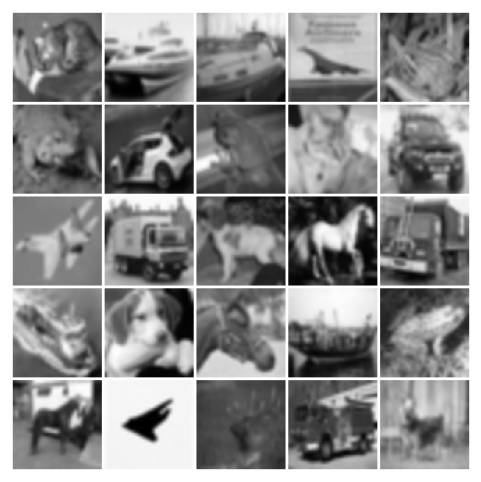

Saved outputs/cifar10_test_25_after_AE_postPPO.png


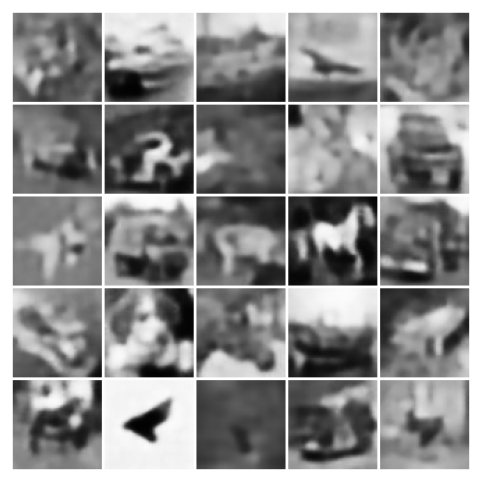

Saved outputs/cifar10_test_25_after_DQN_policy_postPPO.png


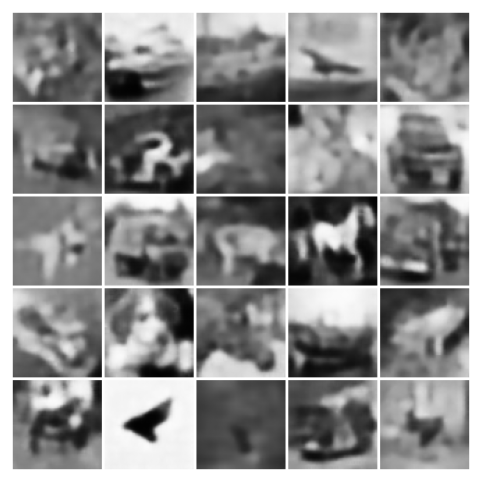

Saved outputs/cifar10_test_25_after_A2C_policy_postPPO.png


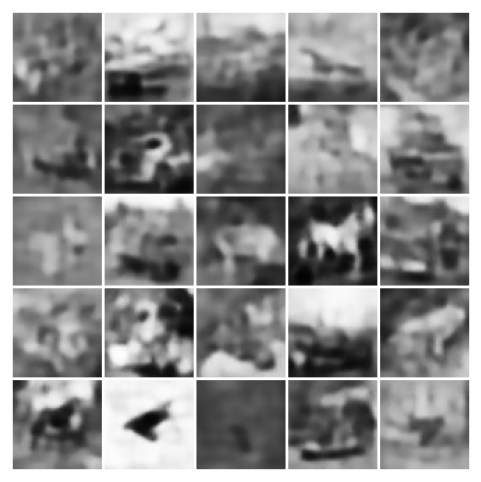

Saved outputs/cifar10_test_25_after_PPO_policy.png


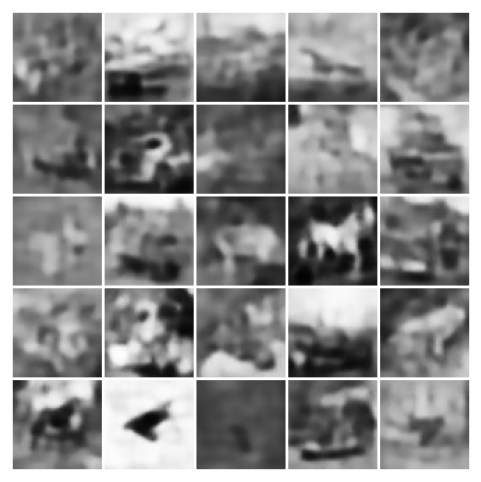

Mean MSE AE (full): 0.0020105522125959396
Mean MSE DQN: 0.002010552129941061 Mean MSE A2C: 0.006525499396957457 Mean MSE PPO: 0.006525499396957457
Saved outputs/recon_mses_all_algos.csv


In [11]:
# Cell C: Evaluate DQN, A2C, PPO on the same sample images and save reconstructions.
# Assumes: sample_imgs is a list/tensor of sample images (earlier made), encoder/decoder exist.

encoder.eval(); decoder.eval(); policy_net.eval(); ac.eval(); ac_ppo.eval()

sample_orig = torch.stack(sample_imgs).to(DEVICE)  # shape (N,1,64,64)
with torch.no_grad():
    z_full = encoder(sample_orig)

# Helper to get reconstruction using a policy (policy_type: 'dqn'|'a2c'|'ppo')
def reconstruct_with_policy(policy_type, model=None):
    recons = []
    mses = []
    for i in range(sample_orig.size(0)):
        obs = z_full[i, :PREVIEW_DIM].cpu().numpy().astype(np.float32)
        s = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            if policy_type == 'dqn':
                act = int(policy_net(s).argmax(dim=1).item())
            elif policy_type == 'a2c':
                dist, _ = ac(s)
                act = int(dist.probs.argmax(dim=1).item())
            elif policy_type == 'ppo':
                dist, _ = ac_ppo(s)
                act = int(dist.probs.argmax(dim=1).item())
            else:
                raise ValueError(policy_type)
            K = K_CHOICES[act]
            z = encoder(sample_orig[i:i+1])
            z_l = z.clone()
            if K < z.shape[1]:
                z_l[:, K:] = 0.0
            rec = decoder.decode(z_l, None)
            recons.append(rec.squeeze(0).cpu())
            mse = F.mse_loss(rec, sample_orig[i:i+1]).item()
            mses.append(mse)
    return recons, mses

# Get AE full recon (before policy truncation)
with torch.no_grad():
    rec_full = decoder.decode(z_full, None)

# Save and show original grid and full AE recon (again, so everything is visible inline)
save_and_show_grid([img.cpu() for img in sample_orig], 'cifar10_test_25_originals_postPPO.png', show_inline=True)
save_and_show_grid([img.cpu() for img in rec_full], 'cifar10_test_25_after_AE_postPPO.png', show_inline=True)

# DQN (already trained earlier)
dqn_recons, dqn_ms = reconstruct_with_policy('dqn')
save_and_show_grid(dqn_recons, 'cifar10_test_25_after_DQN_policy_postPPO.png', show_inline=True)

# A2C
a2c_recons, a2c_ms = reconstruct_with_policy('a2c')
save_and_show_grid(a2c_recons, 'cifar10_test_25_after_A2C_policy_postPPO.png', show_inline=True)

# PPO
ppo_recons, ppo_ms = reconstruct_with_policy('ppo')
save_and_show_grid(ppo_recons, 'cifar10_test_25_after_PPO_policy.png', show_inline=True)

# Print mean MSEs
print('Mean MSE AE (full):', F.mse_loss(rec_full, sample_orig).item())
print('Mean MSE DQN:', np.mean(dqn_ms), 'Mean MSE A2C:', np.mean(a2c_ms), 'Mean MSE PPO:', np.mean(ppo_ms))

# Save consolidated per-image mses to CSV
import csv
with open('outputs/recon_mses_all_algos.csv', 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['idx','mse_ae_full','mse_dqn','mse_a2c','mse_ppo'])
    for i in range(sample_orig.size(0)):
        w.writerow([i,
                    F.mse_loss(rec_full[i:i+1], sample_orig[i:i+1]).item(),
                    dqn_ms[i],
                    a2c_ms[i],
                    ppo_ms[i]])
print('Saved outputs/recon_mses_all_algos.csv')

Saved outputs/comparison_plots_all_algos.png


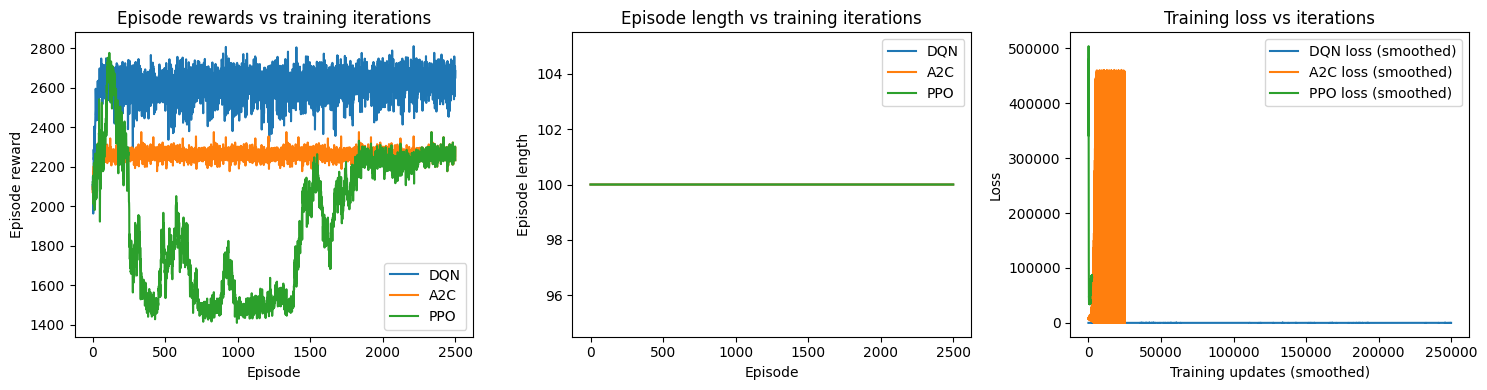

In [12]:
# Cell D: Combined comparison plots for rewards, lengths, and losses across DQN, A2C, PPO.
plt.figure(figsize=(15,4))

# ensure all lists exist: dqn_reward_hist, a2c_reward_hist, ppo_reward_hist
dqn_r = dqn_reward_hist
a2c_r = a2c_reward_hist
ppo_r = ppo_reward_hist

plt.subplot(1,3,1)
plt.plot(dqn_r, label='DQN')
plt.plot(np.linspace(0, len(a2c_r)-1, len(dqn_r)), a2c_r[:len(dqn_r)], label='A2C')
plt.plot(np.linspace(0, len(ppo_r)-1, len(dqn_r)), ppo_r[:len(dqn_r)], label='PPO')
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.legend()
plt.title('Episode rewards vs training iterations')

plt.subplot(1,3,2)
dqn_l = dqn_length_hist
a2c_l = a2c_length_hist
ppo_l = ppo_length_hist
plt.plot(dqn_l, label='DQN')
plt.plot(np.linspace(0, len(a2c_l)-1, len(dqn_l)), a2c_l[:len(dqn_l)], label='A2C')
plt.plot(np.linspace(0, len(ppo_l)-1, len(dqn_l)), ppo_l[:len(dqn_l)], label='PPO')
plt.xlabel('Episode')
plt.ylabel('Episode length')
plt.legend()
plt.title('Episode length vs training iterations')

plt.subplot(1,3,3)
def smooth(x, w=5):
    if len(x) < w: return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

sd = smooth(dqn_loss_hist, w=5) if len(dqn_loss_hist) > 0 else []
sa = smooth(a2c_loss_hist, w=5) if len(a2c_loss_hist) > 0 else []
sp = smooth(ppo_loss_hist, w=5) if len(ppo_loss_hist) > 0 else []
if len(sd)>0: plt.plot(sd, label='DQN loss (smoothed)')
if len(sa)>0: plt.plot(sa, label='A2C loss (smoothed)')
if len(sp)>0: plt.plot(sp, label='PPO loss (smoothed)')
plt.xlabel('Training updates (smoothed)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training loss vs iterations')

plt.tight_layout()
plt.savefig('outputs/comparison_plots_all_algos.png')
print('Saved outputs/comparison_plots_all_algos.png')
plt.show()

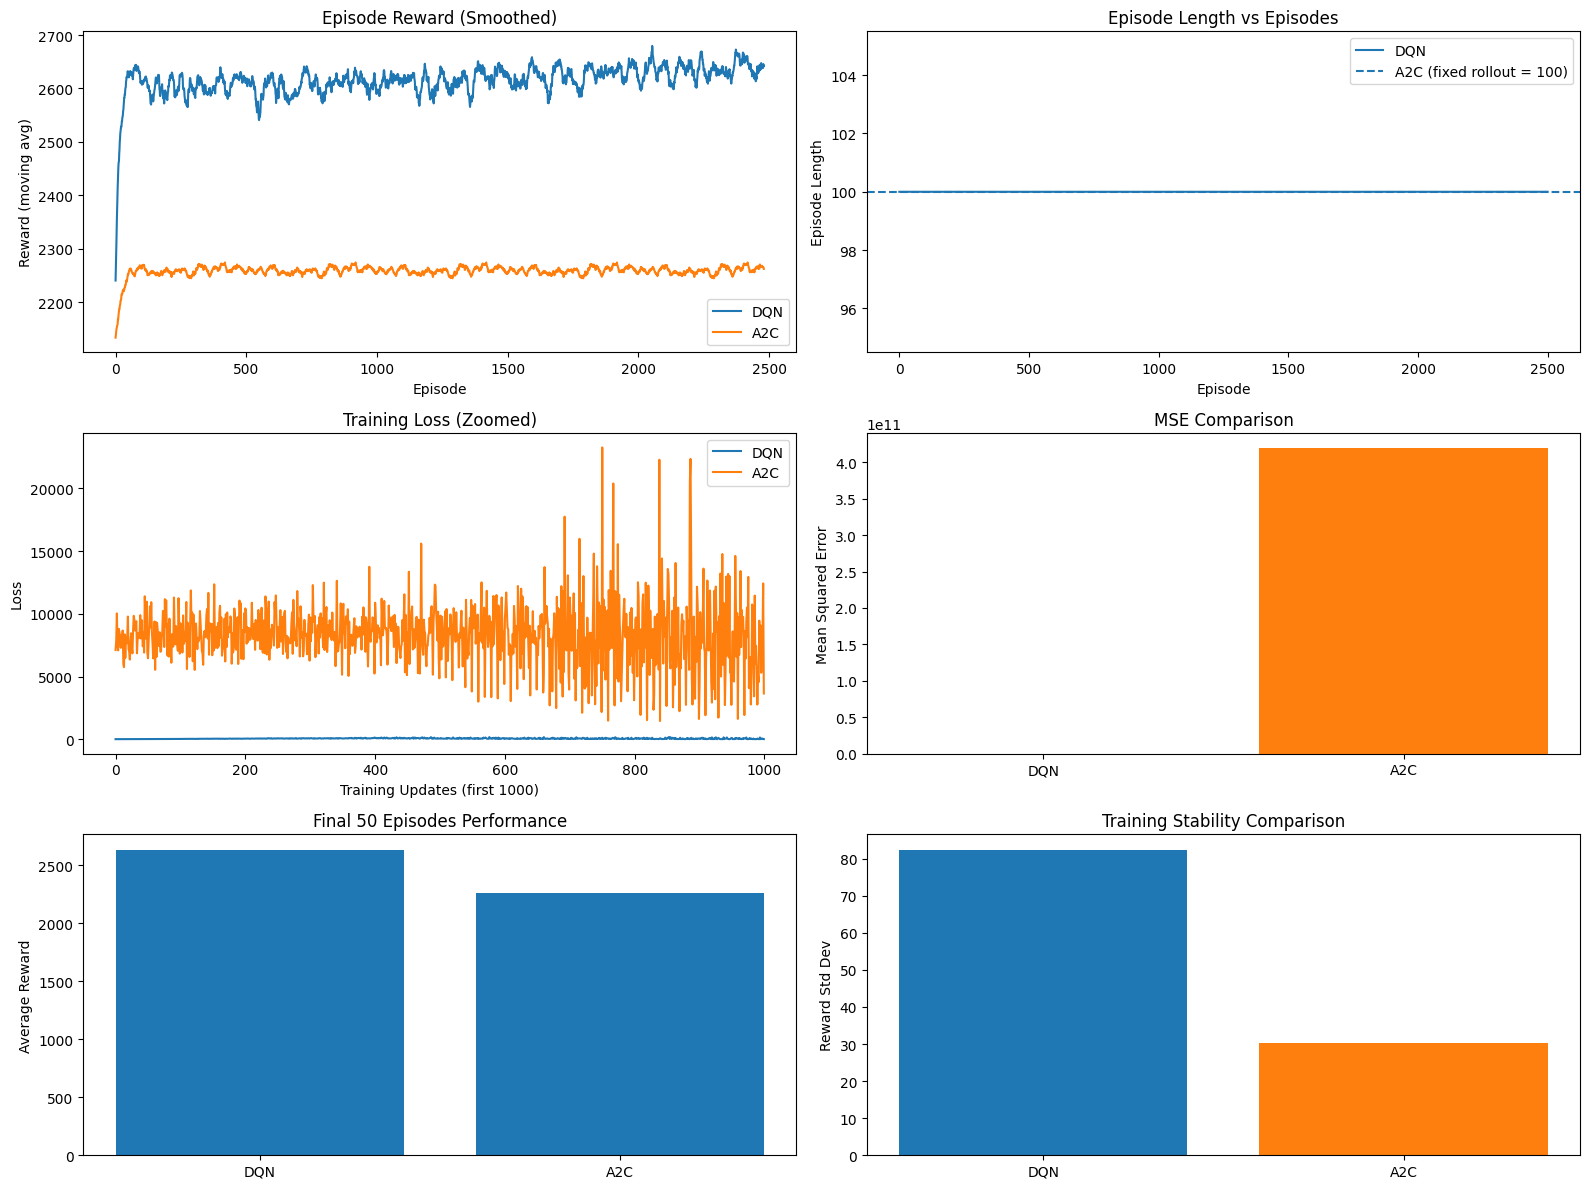

In [13]:
# Improved Visualization

import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w=20):
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(16, 12))

# -------------------------------------------------
# 1. Episode reward (smoothed)
# -------------------------------------------------
plt.subplot(3, 2, 1)
plt.plot(moving_average(dqn_reward_hist), label="DQN")
plt.plot(
    np.linspace(0, len(moving_average(dqn_reward_hist))-1,
                len(moving_average(a2c_reward_hist))),
    moving_average(a2c_reward_hist),
    label="A2C"
)
plt.xlabel("Episode")
plt.ylabel("Reward (moving avg)")
plt.title("Episode Reward (Smoothed)")
plt.legend()

# -------------------------------------------------
# 2. Episode length
# -------------------------------------------------
plt.subplot(3, 2, 2)
plt.plot(dqn_length_hist, label="DQN")
plt.axhline(y=100, linestyle="--", label="A2C (fixed rollout = 100)")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length vs Episodes")
plt.legend()

# -------------------------------------------------
# 3. Training loss (first 1000 updates only)
# -------------------------------------------------
plt.subplot(3, 2, 3)
MAX_UPDATES = 1000

if len(dqn_loss_hist) > 0:
    plt.plot(dqn_loss_hist[:MAX_UPDATES], label="DQN")
if len(a2c_loss_hist) > 0:
    plt.plot(a2c_loss_hist[:MAX_UPDATES], label="A2C")

plt.xlabel("Training Updates (first 1000)")
plt.ylabel("Loss")
plt.title("Training Loss (Zoomed)")
plt.legend()

# -------------------------------------------------
# 4. MSE comparison (critic/value loss proxy)
# -------------------------------------------------
plt.subplot(3, 2, 4)

if len(dqn_loss_hist) > 0:
    dqn_mse = np.mean(np.square(dqn_loss_hist))
    plt.bar("DQN", dqn_mse)

if len(a2c_loss_hist) > 0:
    a2c_mse = np.mean(np.square(a2c_loss_hist))
    plt.bar("A2C", a2c_mse)

plt.ylabel("Mean Squared Error")
plt.title("MSE Comparison")

# -------------------------------------------------
# 5. Final average reward
# -------------------------------------------------
plt.subplot(3, 2, 5)

labels = []
values = []

if len(dqn_reward_hist) > 0:
    labels.append("DQN")
    values.append(np.mean(dqn_reward_hist[-50:]))

if len(a2c_reward_hist) > 0:
    labels.append("A2C")
    values.append(np.mean(a2c_reward_hist[-50:]))

plt.bar(labels, values)
plt.ylabel("Average Reward")
plt.title("Final 50 Episodes Performance")

# -------------------------------------------------
# 6. Reward variance (stability)
# -------------------------------------------------
plt.subplot(3, 2, 6)

if len(dqn_reward_hist) > 0:
    plt.bar("DQN", np.std(dqn_reward_hist))

if len(a2c_reward_hist) > 0:
    plt.bar("A2C", np.std(a2c_reward_hist))

plt.ylabel("Reward Std Dev")
plt.title("Training Stability Comparison")

plt.tight_layout()
plt.show()
